In [168]:
import os
import glob
import pkbar
from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

In [169]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# bookmaker -- An NBA Deep Learning Prediction Model

## Problem Formulation & Motivation

In May of 2018, the U.S. Supreme Court ruled that individual states had the right to legalize sports betting, overturning a longstanding law. Since then, dozens of states have introduced legislation to allow betting sites to operate within their borders, and the cumulative value of the American sports betting market is expected to reach \$8 billion by 2025.

Anecdotally, betting lines are remarkably accurate at predicting outcomes, but as an aggregation of human opinions, they are inherently biased. We believe that we can improve on these group-think predictions by taking a data-driven approach towards odds making. Traditional NBA forecast models use team-based statistics to predict the outcome of games. Here, we've designed a deep learning system that utilizes individualized player data in addition to conventional game statistics to generate more accurate forecasts of team point production in a given match-up.

## Data Sources & Pre-Processing

Constructing the input features of our model required significant pre-processing of our raw data. The raw data was sourced from three primary stores,

1. `NBA.com`
2. `FiveThirtyEight.com`
3. `sportsbookreviewsonline.com`

and covered the years 2015-2020. We scraped raw box score data from `NBA.com` on a per-game basis by a pre-processing script. From `FiveThirtyEight`, we pulled their proprietary RAPTOR data. The `sportsbookreviewsonline` websites hosts Excel files of historical odds data, which we downloaded directly.

We reserved the 2020 season as a `test` year, 2019 as a `validation` year, and the remainder as `train` years.

In [170]:
example_file = os.path.join('data', 'raw', '2015-nba-boxscores.csv')
boxscore_data = pd.read_csv(example_file, index_col=0)
boxscore_data.sample(5)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
31285,21400013,1610612747,LAL,Los Angeles,201941,Jordan Hill,C,NaN,25:26,2.0,...,5.0,6.0,11.0,2.0,0.0,0.0,0.0,4.0,6.0,-24.0
19339,21400470,1610612742,DAL,Dallas,202962,Greg Smith,NaN,NaN,20:53,3.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,8.0,10.0
26609,21400186,1610612739,CLE,Cleveland,2034,Mike Miller,NaN,NaN,12:13,1.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0
16318,21400599,1610612746,LAC,Los Angeles,2563,Dahntay Jones,NaN,NaN,4:28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-9.0
16025,21400603,1610612744,GSW,Golden State,101106,Andrew Bogut,C,NaN,19:55,1.0,...,1.0,5.0,6.0,2.0,0.0,2.0,3.0,3.0,2.0,12.0


In [171]:
example_file = os.path.join('data', 'raw', 'odds-2014-15.xlsx')
odds_data = pd.read_excel(example_file)
odds_data.head(10)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,1028,501,V,Dallas,24,29,20,27,100,206.5,203.5,140,102
1,1028,502,H,SanAntonio,26,19,31,25,101,6,3.5,-165,4
2,1028,503,V,Orlando,25,16,23,20,84,196,191,380,94.5
3,1028,504,H,NewOrleans,24,24,30,23,101,9.5,9,-475,3.5
4,1028,505,V,Houston,31,31,23,23,108,6.5,7,-300,103
5,1028,506,H,LALakers,19,26,24,21,90,209,207,250,1.5
6,1029,701,V,Milwaukee,24,33,26,17,106,192,193,315,97
7,1029,702,H,Charlotte,25,21,22,32,108,9,8,-390,7.5
8,1029,703,V,Philadelphia,24,27,19,21,91,194,189.5,290,95
9,1029,704,H,Indiana,26,22,30,25,103,8.5,7.5,-350,6


Historical player statistics are typically calculated on a per-season basis. One could use a player's prior season statistics, but this quickly become stale and fail to capture improvements player's make throughout a season. To remedy this, we manually computed "live" statistics. In our pre-processing, we essentially constructed a massive hash table where you could look up current statistics for any date/player pair.

Additionally, the raw odds data was very unstructed and required significant cleaning.

## Model Features and Architecture

We chose to have our model predict the points scored for a single team in a given matchup. One benefit of this decision is that it effectively doubles our training data, since each game results in two observations. Additionally, it gives us some flexibility in evaluating our model. With a predicted score for each team, we can form predictions of both the `spread` and the `over/under`. 

The downside is that our model is not explicitly trained to perfrom well on predicting either the `spread` **or** the `over/under`. 

We limited our analysis to the five starting players, plus a "top" sub defined by minutes played. Doing so could potentially cause a situation where one team's starters have "better" absolute stats simply by playing more minutes. To account for this, we standarized all statistics per 48 minutes. The final features for our model are as follows:
* `this` - (team we are predicting)
    * C1
        * PTS
        * ASTS
        * OREBS
        * FGM
        * FGA
        * FG3M
        * FG3A
        * FTM
        * FTA
    * G1
    * G2
    * F1
    * F2
    * S1
* `other` - (team we are playing against)
    * C1
        * STL
        * DREB
        * BLK
        * TO
    * G1
    * G2
    * F1
    * F2
    * S1
    
For a total of `(6 * 9) + (6 * 4) = 78` total features. All features are Z-score normalized before being piped to the network. This transforms all our features to a comparable scale, and gives us a nice smooth loss curve, as we'll see.

In [172]:
def load_model_data(_type: str) -> Tuple[pd.MultiIndex, torch.tensor, torch.tensor]:
    """
    Retrieve features and score outcomes from the proper data directory so 
    we can feed them into a PyTorch model.
    
    Parameters:
        _type: Choose from {'train', 'dev', 'test'}
        
    Returns:
        A 3-tuple consisting of
            1) A pd.MultiIndex so we can associate the outcomes predicted
            by our model to a particular gameid/teamid
            
            2) A 2D torch.tensor of player/team features normalized by column
            
            3) A 1D torch.tensor that represents the points scored by a team
            in a particular game.
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
    
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-data-raptor.csv')
    for fp in glob.glob(data_path):
        season = pd.read_csv(fp)
        # Convert string tuples to actual tuples
        season = season.rename(columns=lambda x: eval(x))
        season = season.set_index([('GAME_ID', '', ''), ('TEAM_ID', '', '')])
        df = df.append(season)
    
    outcome_col = ('TEAM_PTS', '', '')
    features = df[df.columns.difference([outcome_col])]
    # Normalize features
    features = (features - features.mean()) / features.std()
    # Need to keep this a DataFrame so our dimensions work in PyTorch
    scores = df[[outcome_col]]
    
    n_features = len(features.columns)
    n_output = len(scores.columns)
    msg = 'Uh oh, you might be losing features!'
    assert n_features + n_output == len(df.columns), msg
    
    features = torch.from_numpy(features.to_numpy(dtype='float32'))
    scores = torch.from_numpy(scores.to_numpy(dtype='float32'))
    
    simple_index = df.index.rename(['GAME_ID', 'TEAM_ID'])
    return simple_index, features, scores

In [173]:
def load_odds_data(_type: str) -> pd.DataFrame:
    """
    Load the odds DataFrame for a certain domain.
    
    Parameters:
        _type: Choose from 'train', 'dev', or 'test'
        
    Returns:
        A pd.DataFrame indexed by (GAME_ID, TEAM_ID)
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
        
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-odds.csv')
    for fp in glob.glob(data_path):
        season_df = pd.read_csv(fp, index_col=[0, 1])
        df = df.append(season_df)
        
    df = df.reset_index()
    df = df.set_index(['GAME_ID', 'TEAM_ID'])
    return df

In [174]:
#https://tomekkorbak.com/2020/06/26/implementing-attention-in-pytorch/
class Attention(torch.nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

    def forward(self, 
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
        ):
        weights = self._get_weights(query, values) # [seq_length]
        weights = torch.nn.functional.softmax(weights, dim=0)
        return weights @ values  # [encoder_dim]
    
class MultiplicativeAttention(Attention):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__(encoder_dim, decoder_dim)
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def _get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [seq_length]
        return weights/np.sqrt(self.decoder_dim)  # [seq_length]

In [294]:
class Attn_Net(nn.Module):
    def __init__(self, input_dim, H, output_dim = 1):
        super(Attn_Net, self).__init__()
        self.attn1 = MultiplicativeAttention(input_dim, input_dim)
        self.linear1 = nn.Linear(input_dim, H)
        self.bn1 = nn.BatchNorm1d(H)
        
        self.attn2 = MultiplicativeAttention(H, H)
        self.linear2 = nn.Linear(H, H//2)
        self.bn2 = nn.BatchNorm1d(H//2)
        self.linear3 = nn.Linear(H//2, output_dim)
        
    def forward(self, x):
        x = self.attn1(x, x)
        x = F.relu(self.linear1(x))
        x = self.bn1(x)
        
        x = self.attn2(x,x)
        x = F.relu(self.linear2(x))
        x = self.bn2(x)
        x = self.linear3(x)
        return x

In [295]:
def log_two_layers(n: int) -> List[Union[nn.Linear, nn.ReLU]]:
    """
    Given an input with n features, construct a series
    of neural network layers that decrease logarithmically.
    """
    shift_bit_length = lambda x: 1 << (x - 1).bit_length() - 1
    
    layers = []
    while n > 4:
        power_of_two = shift_bit_length(n)
        # nn.Linear uses Xavier initialization
        layers.append( nn.Linear(n, power_of_two) )
        layers.append( nn.ReLU() )
        n = power_of_two
    # Now n == 4 and we add a final regression layer
    layers.append( nn.Linear(n, 1) )
    return layers

In [296]:
_, x_train, y_train = load_model_data('train')

In [297]:
x_train.shape[1]

127

Due to the relative scarcity of data, our training time is quick, allowing us to experiment with deeper networks. We employ a novel "log two" neural network that has approximately `log_2(n)` layers, where `n` is the number of features.

Throughout the course of an NBA season, you'll have several 50 and 60 points performances, which even the most astute model would have trouble predicting. In this context, `L1` loss is a more appropriate measure as it does not penalize outliers as severely.

## Model Training

In [298]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 500
batch_size = 100
learning_rate = 0.0001
pbar = pkbar.Pbar(name='Training Model', target = num_epochs)

# Load data as torch.tensors
_, x_train, y_train = load_model_data('train')
_, x_validate, y_validate = load_model_data('dev')

# Define our model layers by decreasing powers of two
# model = nn.Sequential( *log_two_layers(x_train.shape[1]) )
model = Attn_Net(x_train.shape[1], x_train.shape[1] // 2)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_ds = TensorDataset(x_train, y_train)
# Notice we shuffle our training data so the seasons are mixed!
train_dl = DataLoader(train_ds, batch_size=batch_size, 
                      shuffle=True)

validate_ds = TensorDataset(x_validate, y_validate)
validate_dl = DataLoader(validate_ds, 
                         batch_size=batch_size * 2)

# L1 loss is more robust to outliers
loss_func = F.smooth_l1_loss

losses = []
for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        epoch_loss = sum(loss_func(model(xb), yb) for xb, yb in validate_dl)
        losses.append( epoch_loss / len(xb) )
    pbar.update(epoch)

Training Model
500/500  [==============================] - 165.0s


In [299]:
total_diff = loss_fi(model(x_validate) - y_validate).detach()

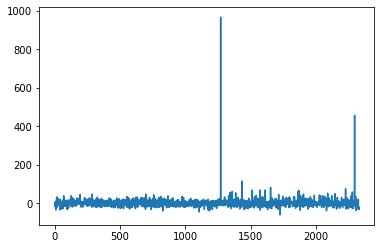

In [300]:
plt.plot(absdiff)

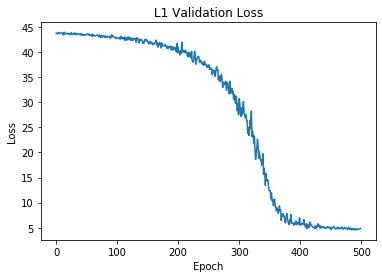

In [301]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

## Model Evaluation

In [302]:
def score(
        model: nn.Sequential, 
        bet: str, 
        category: str,
        buffer: float=1.
) -> Tuple[int, int, int]:
    """
    This function handles some preliminary data loading tasks before redirecting to 
    the more specific _score_spread() and _score_overunder() functions.
    
    Parameters:
        model: The ANN object with learned parameters
        bet: Either 'spread' or 'over/under'
        category: Either 'open' or 'close'
        buffer: How much our model must contradict the odds to place a bet.
                Otherwise we just 'push' and don't take any action.
        
    Returns:
        A three-tuple consisting of (bets won, bets lost, bets pushed)
    """
    if buffer < 0:
        raise RuntimeError(f' {buffer} makes no sense')
        
    if category not in {'open', 'close'}:
        raise RuntimeError(f" {category} not valid, must be in ['open', 'close']")
    
    i_test, x_test, y_test = load_model_data('test')
    y_predicted = model(x_test)
    
    # pd.Series are way easier to handle than tensors
    y_hat = pd.Series(y_predicted.detach().squeeze(), index=i_test)
    y = pd.Series(y_test.detach().squeeze(), index=i_test)

    odds = load_odds_data('test').dropna()
    intersection = odds.index.intersection(i_test)

    # Drop some games, since our prepared NBA data doesn't contain
    # every game in the season.
    odds = odds.loc[intersection]
    y_hat = y_hat.loc[intersection]
    y = y.loc[intersection]
    
    # Check that both data sources agree on the points scored
    assert (y == odds['pts']).all()

    if bet == 'over/under':
        return _score_overunder(model, odds[f'ou_{category}'], 
                                y, y_hat, buffer)
    
    elif bet == 'spread':
        return _score_spread(model, odds[f'spread_{category}'], 
                             y, y_hat, buffer)
        
    else:
        msg = f"{bet} not valid, must be in ['over/under', 'spread']"
        raise RuntimeError(msg)

In [303]:
def _score_spread(
        model: nn.Sequential, 
        odds: pd.Series, 
        y: pd.Series, 
        y_hat: pd.Series,
        buffer: float=1.
) -> Tuple[int, int, int]:
    """
    Given a 'buffer', determine how many 'spread' bets we would have
    placed and won.
    
    Parameters:
        model: ANN with trained model parameters
        odds: A slice of the original df with either 'open' or 'close'
        y: Actual score outcomes per team
        y_hat: Predicted score outcomes per team
        buffer: A measure of how much our model must contradict the odds
                in order to place a bet.
                
    Returns:
        A three-tuple consisting of (games won, games lost, no action taken)
    """
    # We need to divided be -2 here because the favorite is always given a negative
    # spread, but we actually want a positive difference with the opponent
    bookie = odds.groupby(level='GAME_ID').diff().dropna() / -2
    actual_spreads = y.groupby(level='GAME_ID').diff().dropna()
    model_spreads = y_hat.groupby(level='GAME_ID').diff().dropna()
    
    long = model_spreads - buffer > bookie
    won_long = long & (actual_spreads > bookie)
    
    short = model_spreads + buffer < bookie
    won_short = short & (actual_spreads < bookie)
    
    push = ~long & ~short
    
    won = won_long.sum() + won_short.sum()
    lost = long.sum() + short.sum() - won
    pushed = push.sum()
    
    return won, lost, pushed

In [304]:
def _score_overunder(
        model: nn.Sequential, 
        odds: pd.Series, 
        y: pd.Series, 
        y_hat: pd.Series,
        buffer: float=1.
) -> Tuple[int, int, int]:
    """
    Given a 'buffer', determine how many over/under bets we would have
    placed and won.
    
    Parameters:
        model: ANN with trained model parameters
        odds: A slice of the original df with either 'open' or 'close'
        y: Actual score outcomes per team
        y_hat: Predicted score outcomes per team
        buffer: A measure of how much our model must contradict the odds
                in order to place a bet.
                
    Returns:
        A three-tuple consisting of (games won, games lost, no action taken)
    """
    bookie = odds.groupby(level='GAME_ID').first()
    actual_totals = y.groupby(level='GAME_ID').sum()
    model_totals = y_hat.groupby(level='GAME_ID').sum()
    
    long = model_totals + buffer < bookie
    won_long = long & (actual_totals < bookie)
    
    short = model_totals - buffer > bookie
    won_short = short & (actual_totals > bookie)
    
    push = ~long & ~short
    
    won = won_long.sum() + won_short.sum()
    lost = long.sum() + short.sum() - won
    pushed = push.sum()
    
    return won, lost, pushed

In [305]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 60, 2):
    won, lost, pushed = score(model, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 519  477    0 0.521 0.000
	 2 420  380  196 0.525 0.197
	 4 321  298  377 0.519 0.379
	 6 240  225  531 0.516 0.533
	 8 177  170  649 0.510 0.652
	10 122  123  751 0.498 0.754
	12  85   80  831 0.515 0.834
	14  61   53  882 0.535 0.886
	16  44   34  918 0.564 0.922
	18  33   23  940 0.589 0.944
	20  20   18  958 0.526 0.962
	22  14   14  968 0.500 0.972
	24   8    9  979 0.471 0.983
	26   5    8  983 0.385 0.987
	28   4    7  985 0.364 0.989
	30   4    6  986 0.400 0.990
	32   3    5  988 0.375 0.992
	34   3    5  988 0.375 0.992
	36   2    4  990 0.333 0.994
	38   2    4  990 0.333 0.994
	40   1    2  993 0.333 0.997
	42   1    1  994 0.500 0.998
	44   1    1  994 0.500 0.998
	46   1    1  994 0.500 0.998
	48   1    1  994 0.500 0.998
	50   1    1  994 0.500 0.998
	52   1    1  994 0.500 0.998
	54   1    0  995 1.000 0.999
	56   1    0  995 1.000 0.999
	58   1    0  995 1.000 0.999


In [306]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 50, 2):
    won, lost, pushed = score(model, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 524  472    0 0.526 0.000
	 2 425  357  214 0.543 0.215
	 4 337  284  375 0.543 0.377
	 6 264  217  515 0.549 0.517
	 8 204  164  628 0.554 0.631
	10 147  122  727 0.546 0.730
	12 104   85  807 0.550 0.810
	14  75   50  871 0.600 0.874
	16  47   31  918 0.603 0.922
	18  35   21  940 0.625 0.944
	20  24   15  957 0.615 0.961
	22  15   14  967 0.517 0.971
	24  11    9  976 0.550 0.980
	26   9    7  980 0.562 0.984
	28   6    7  983 0.462 0.987
	30   6    6  984 0.500 0.988
	32   6    6  984 0.500 0.988
	34   5    5  986 0.500 0.990
	36   4    4  988 0.500 0.992
	38   4    3  989 0.571 0.993
	40   3    2  991 0.600 0.995
	42   3    2  991 0.600 0.995
	44   3    1  992 0.750 0.996
	46   3    1  992 0.750 0.996
	48   3    1  992 0.750 0.996


In [307]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = score(model, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 483  513    0 0.485 0.000
	 2 382  398  216 0.490 0.217
	 4 271  284  441 0.488 0.443
	 6 181  179  636 0.503 0.639
	 8 113  115  768 0.496 0.771
	10  68   70  858 0.493 0.861
	12  48   47  901 0.505 0.905
	14  27   35  934 0.435 0.938
	16  21   25  950 0.457 0.954
	18  14   18  964 0.438 0.968
	20  12   15  969 0.444 0.973
	22   7    9  980 0.438 0.984
	24   6    8  982 0.429 0.986
	26   6    8  982 0.429 0.986
	28   6    8  982 0.429 0.986


In [308]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = score(model, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 492  504    0 0.494 0.000
	 2 396  388  212 0.505 0.213
	 4 281  268  447 0.512 0.449
	 6 190  184  622 0.508 0.624
	 8 112  119  765 0.485 0.768
	10  68   76  852 0.472 0.855
	12  45   48  903 0.484 0.907
	14  30   33  933 0.476 0.937
	16  25   25  946 0.500 0.950
	18  17   19  960 0.472 0.964
	20  13   13  970 0.500 0.974
	22  11   10  975 0.524 0.979
	24   9    8  979 0.529 0.983
	26   8    8  980 0.500 0.984
	28   8    8  980 0.500 0.984


## Open Questions

* Would directly predicting `spread` or `over/under` work better?
* Can attention layers help learn the interactions of different players on the court
* What other features would prove helpful?